<a href="https://colab.research.google.com/github/bhonsleaditya1/Lending-Club-PySpark/blob/master/Lending_Club_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /content/XGBoost-Spark/xgboost4j_2.12-1.0.0.jar,/content/XGBoost-Spark/xgboost4j-spark_2.12-1.0.0.jar pyspark-shell'

In [ ]:
cp -r '/content/drive/My Drive/Lending-Club/XGBoost-Spark/' '/content'

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "30g").config("spark.executor.memory", "25g").getOrCreate()
spark.sparkContext.addPyFile("/content/XGBoost-Spark/sparkxgb.zip")

In [ ]:
!pip install -q bayesian-optimization
!pip install -q scikit-optimize

In [ ]:
import os,gc,re,matplotlib,joblib
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection  import StratifiedKFold,train_test_split,cross_validate
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,LabelEncoder
from sklearn.metrics import roc_auc_score,auc,roc_curve,accuracy_score,classification_report,confusion_matrix,f1_score,make_scorer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from scipy.stats import zscore
from sklearn import model_selection 
from bayes_opt import BayesianOptimization
from sklearn.cluster import DBSCAN
#import pyspark.sql.functions as f
#from pyspark.sql.types import IntegerType,DateType,DoubleType,StringType
#from pyspark.ml.feature import QuantileDiscretizer
#from pyspark.sql.functions import log,unix_timestamp, from_unixtime,lit
#from pyspark.sql import Window 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
newdf = spark.read.csv('/content/drive/My Drive/Lending-Club/loanFinal.csv',inferSchema=True, header =True)
#newdf = newdf.cache()
newdf01 = newdf.filter(newdf.target !=2)

In [ ]:
pdf = pd.read_csv('/content/drive/My Drive/Lending-Club/loanFinal.csv', header=0, escapechar='\\')
dropcol = pd.read_csv('/content/drive/My Drive/Lending-Club/FinalDrop.csv',header=None)[0].to_list()
dbindex = pd.read_csv('/content/drive/My Drive/Lending-Club/DBRemove.csv')
dropcol.append('pymnt_plan')
pdf = pdf[pdf.amnt_left_per<=100]
pdf = pdf.drop(dropcol,axis=1)
pdf=pdf[pdf['application_type'].isin(['Joint App','Individual'])]
pdf=pdf[pdf['initial_list_status'].isin(['w','f'])]
pdf = pdf.drop(dbindex['index'].to_list())
pdf = pdf.reset_index().drop('index',axis=1)
pdf.count()
pdf['year'] = pd.DatetimeIndex(pdf['issue_d']).year
#pdf = pdf.drop(dt,axis=1)
reg = pdf.select_dtypes(['float64']).columns
clas = pdf.select_dtypes(['O']).columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,49,117,118,119,122,123,124,127) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
del pdf
gc.collect()

2411

In [ ]:
#OneHotEncoding 2 vs R
pdf.loc[pdf['target']==1,'target']=0
pdf.loc[pdf['target']==2,'target']=1
p = pd.DataFrame(index=None)
for i in clas:
  if pdf[i].nunique()<25:
    l = pd.get_dummies(pdf[i], prefix=i)
    for j in l.columns:
      pdf[j] = l[j]
for i in clas:
  pdf = pdf.drop(i,axis=1)
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
timetest = timetest.drop(['year'],axis=1)
train = train.drop(['year'],axis=1)
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)

In [ ]:
p = pd.DataFrame(index=None)
for i in clas:
  if pdf[i].nunique()<25:
    l = pd.get_dummies(pdf[i], prefix=i)
    for j in l.columns:
      pdf[j] = l[j]
for i in clas:
  pdf = pdf.drop(i,axis=1)
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})

In [ ]:
pdf = pdf[pdf['target']!=2]
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)

NameError: ignored

In [ ]:
del pdf
gc.collect()

18762

In [ ]:
zpdf = pd.DataFrame(index=None)
for col in reg:
  zpdf[col] = pdf[col]

In [ ]:
from scipy import stats
import numpy as np
from tqdm import tqdm

z = stats.zscore(zpdf)

In [ ]:
z = np.abs(z)

In [ ]:
threshold = 2.5
remove = np.where(z > 2.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [ ]:
z = stats.zscore(zpdf['int_rate'])

(array([      4,      16,      55, ..., 1337980, 1337982, 1337983]),)

In [ ]:
stats.zscore(zpdf['installment'])

array([ 2.71560294,  2.04587762,  0.69829638, ..., -0.28554519,
        0.96137685, -0.31199829])

In [ ]:
mis = {}
for col in pdf:
  mis[col] = pdf[col].isna().mean().round(4)*100

In [ ]:
columns = newdf.columns
norows = newdf.count()
types = [f.dataType for f in newdf.schema.fields]
typ = {columns[i]: types[i] for i in range(len(types))}
columns.remove('target')
print(len(columns))
print(len(drop))
for col in drop:
  columns.remove(col)
  newdf = newdf.drop(col)
  newdf01 = newdf01.drop(col)
print(len(columns))

141
70
71


In [ ]:
clas = []
date = []
reg = []
cols=[]
for col in columns:
  if str(typ[col]) == 'StringType':
    clas.append(col)
  elif str(typ[col])=='TimestampType':
    date.append(col)
  else:
    reg.append(col)

In [ ]:
pdf = newdf01.toPandas()

In [ ]:
import gc
gc.collect()

0

In [ ]:
pdf = pdf[pdf['target']!=2]
#pdf.loc[pdf['target']==2,'target']=1
clas = pdf.select_dtypes(include=['O']).columns
lb_make = LabelEncoder()
for col in clas:
  pdf[col] = pdf[col].astype(str).fillna('')
  pdf[col]=lb_make.fit_transform(pdf[col])
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)

In [ ]:
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
predictions = gbm.predict(X_test)
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


13

In [ ]:
features = ['term',
 'int_rate',
 'grade',
 'sub_grade',
 'home_ownership',
 'issue_d',
 'initial_list_status',
 'total_rec_late_fee',
 'last_pymnt_d',
 'last_credit_pull_d',
 'mort_acc',
 'num_tl_120dpd_2m']

In [ ]:
def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    err = gini
    return 'gini_err', err
dtrain = xgb.DMatrix(X_train,label=y_train)
result = {}
dtest = xgb.DMatrix(X_test,y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
params = {
    'max_depth':8,
    'n_estimators':800,
    'reg_lambda':6,
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'scale_pos_weight':10,
    #'num_class':3
}
classifier = xgb.XGBClassifier(**params,num_boost_round=500,dtrain=dtrain,feval=gini_eval,evals=watchlist,early_stopping_rounds=30,evals_result=result)
#classifier= OneVsRestClassifier(model)
#,eval_metric='mlogloss' ,eval_set=eval_set,early_stopping_rounds=30)
classifier.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              dtrain=<xgboost.core.DMatrix object at 0x7f5ba91326a0>,
              early_stopping_rounds=30,
              evals=[(<xgboost.core.DMatrix object at 0x7f5ba91326a0>, 'train'),
                     (<xgboost.core.DMatrix object at 0x7f5bacf75198>, 'eval')],
              evals_result={}, feval=<function gini_eval at 0x7f5ba8c2d840>,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, num_boost_round=500, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=6, scale_pos_weight=10,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

In [ ]:
eval_set=[(X_test,y_test)]
def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    print(y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2 - 2*roc_auc
    err = gini
    return 'gini_err', err

classifier = xgb.XGBClassifier(max_depth=8,n_estimators=800,reg_lambda=6,objective='binary:logistic',n_gpus=1,tree_method='hist',scale_pos_weight=10)
classifier.fit(X_train,y_train['target'],eval_metric='logloss' ,eval_set=eval_set,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-logloss:0.638945
Will train until validation_0-logloss hasn't improved in 30 rounds.
[1]	validation_0-logloss:0.594611
[2]	validation_0-logloss:0.558025
[3]	validation_0-logloss:0.528078
[4]	validation_0-logloss:0.502158
[5]	validation_0-logloss:0.479459
[6]	validation_0-logloss:0.460783
[7]	validation_0-logloss:0.443699
[8]	validation_0-logloss:0.428972
[9]	validation_0-logloss:0.416499
[10]	validation_0-logloss:0.405819
[11]	validation_0-logloss:0.395928
[12]	validation_0-logloss:0.387233
[13]	validation_0-logloss:0.37809
[14]	validation_0-logloss:0.371401
[15]	validation_0-logloss:0.364628
[16]	validation_0-logloss:0.359267
[17]	validation_0-logloss:0.353807
[18]	validation_0-logloss:0.348831
[19]	validation_0-logloss:0.345012
[20]	validation_0-logloss:0.341697
[21]	validation_0-logloss:0.336038
[22]	validation_0-logloss:0.332165
[23]	validation_0-logloss:0.329696
[24]	validation_0-logloss:0.327034
[25]	validation_0-logloss:0.324472
[26]	validation_0-logloss:0.32057

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=800, n_gpus=1,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=6, scale_pos_weight=10,
              seed=None, silent=None, subsample=1, tree_method='hist',
              verbosity=1)

In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train[features], label=y_train)
cvvalues = []
ginivalues=[]
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth,gamma,n_estimators,learning_rate,reg_alpha,scale_pos_weight,colsamplebytree,max_delta_step):
  global cvvalues,ginivalues
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'reg_alpha':reg_alpha,
          'scale_pos_weight':scale_pos_weight,
          'colsamplebytree':colsamplebytree,
          'eval_metric': 'error',
          'objective': 'binary:logistic',
          #'num_class':3,
          'max_delta_step':max_delta_step,
          'tree_method':'gpu_hist'
          }
  #Cross validating with the specified parameters in 5 folds and 70 iterations
  cv_result = xgb.cv(params, dtrain, num_boost_round=50, nfold=5,feval=gini_eval
                     #metrics='logloss'
                     )
  #Return the negative RMSE
  cvvalues.append(cv_result)
  return cv_result['test-error-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'gamma': (0, 1),
                                            'scale_pos_weight': (7,14),                                          
                                            'n_estimators':(100,1000),
                                            'reg_alpha': (0,1),
                                            'learning_rate': (0.01,0.5),
                                            'colsamplebytree':(0,1),
                                            'max_delta_step':(0,1)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

KeyError: ignored

In [ ]:
p = pd.DataFrame(index=None)
for i in cvvalues:
  p=p.append(i)
p.to_excel('/content/drive/My Drive/Lending-Club/01_error.xlsx')
pd.DataFrame(xgb_bo.res).to_excel('/content/drive/My Drive/Lending-Club/01_error_params.xlsx')

In [ ]:
p = pd.DataFrame.from_dict(xgb_bo.res)

In [ ]:
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  gc.collect()
  return gini

In [ ]:
gini={}
gini_train={}
gini_time={}
f1={}
f1_train={}
f1_time={}
p = pd.DataFrame.from_dict(xgb_bo.res)
for i in range(10):
  para=p['params'][i]
  para['n_estimators']=int(para['n_estimators'])
  para['max_depth']=int(para['max_depth'])
  para['scale_pos_weight']=int(para['scale_pos_weight'])
  para['objective'] = 'binary:logistic'
  para['tree_method'] = 'gpu_hist'
  #para['num_class'] = 3
  #dtrain = xgb.DMatrix(X_train,label=y_train)
  clf = xgb.XGBClassifier(**para,n_jobs=8).fit(X_train,y_train)
  res = clf.predict_proba(X_test)
  gini[i]=calc_gini(y_test,res,2)
  res = clf.predict(X_test)
  f1[i]=f1_score(y_test,res,average=None)
  res = clf.predict_proba(X_train)
  gini_train[i]=calc_gini(y_train,res,2)
  res = clf.predict(X_train)
  f1_train[i]=f1_score(y_train,res,average=None)
  res = clf.predict_proba(timetest)
  gini_time[i]=calc_gini(y_timetest,res,2)
  res = clf.predict(timetest)
  f1_time[i]=f1_score(y_timetest,res,average=None)
  gc.collect()
  #fscores = pd.DataFrame({'X': list(clf.get_fscore().keys()), 'Y': list(clf.get_fscore().values())})
  #plt.figure(i)
  #fscores.sort_values(by='Y')[:20].plot.bar(x='X')
#result = clf.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [ ]:
pd.DataFrame.from_dict(f1_time)

,0,1,2,3,4,5,6,7,8,9
0,0.927415,0.927993,0.92798,0.892691,0.930856,0.944170,0.943181,0.917591,0.931664,0.941540
1,0.600964,0.588563,0.57310,0.515378,0.616427,0.577182,0.584332,0.576911,0.597607,0.563486


In [ ]:
params = xgb_bo.max['params']
print(params)
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['scale_pos_weight'] = int(params['scale_pos_weight'])
params['tree_method'] = 'gpu_hist'
dtrain = xgb.DMatrix(X_train,label=y_train)
classifier = xgb.XGBClassifier(**params,n_jobs=8).fit(X_train,y_train)

{'colsamplebytree': 0.0, 'gamma': 1.0, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 3.0, 'n_estimators': 266.1698318372242, 'reg_alpha': 1.0, 'scale_pos_weight': 7.0}


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.10229089, 0.01296562, 0.01608621, 0.02684456, 0.        ,
       0.        , 0.        , 0.01111861, 0.        , 0.01219587,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07339741, 0.0096605 ,
       0.04726292, 0.        , 0.        , 0.02804903, 0.03840835,
       0.00781928, 0.04790387, 0.01941868, 0.        , 0.0085356 ,
       0.01633597, 0.02898834, 0.02720449, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02191676, 0.01356783, 0.        , 0.        , 0.        ,
       0.        , 0.0078159 , 0.02310387, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00311774,
       0.        , 0.        , 0.        , 0.01766138, 0.        ,
       0.02241414, 0.11375534, 0.        , 0.08648236, 0.08071961,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
features

['int_rate',
 'open_acc_6m',
 'mort_acc',
 'num_actv_rev_tl',
 'term_36 months',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'pymnt_plan_n']

In [ ]:
classifier = xgb.XGBClassifier(objective='binary:logistic',tree_method='gpu_hist')
classifier.fit(X_train[features].fillna(-999999),y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

0.2687762730033385
0.26877625084462053
0.0
0.25978165498704353
0.25978166655792423
0.0
0.26753455490908973
0.2675345801802249
0.0


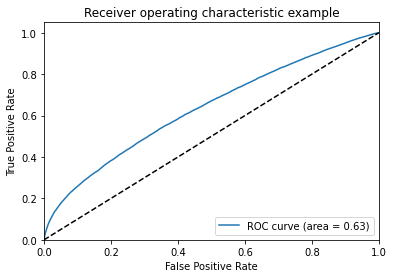

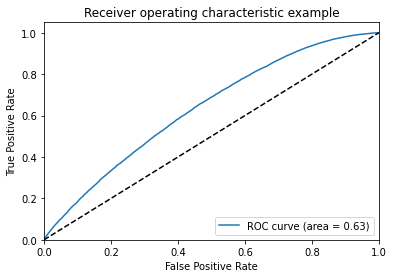

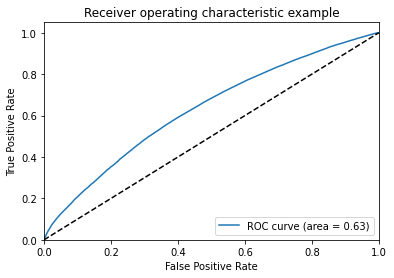

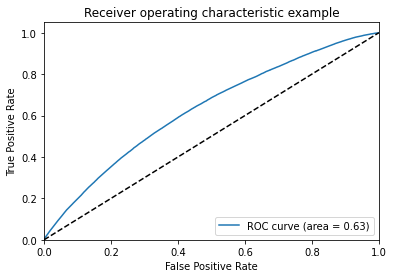

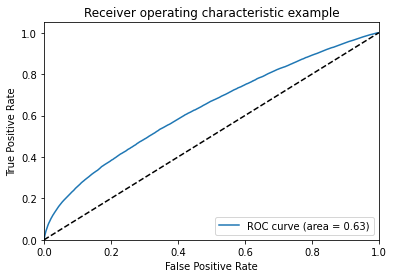

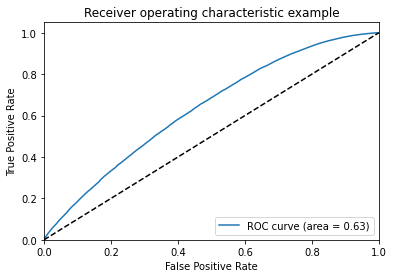

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
gini =0
y_predtrain=classifier.predict_proba(X_train[features]) 
y_pred=classifier.predict_proba(X_test[features])
y_predtime=classifier.predict_proba(timetest[features])
drop_enc = OneHotEncoder().fit(pd.DataFrame(y_test))
y_gini = drop_enc.transform(pd.DataFrame(y_test)).toarray()
drop_enc = OneHotEncoder().fit(pd.DataFrame(y_timetest))
y_ginitime = drop_enc.transform(pd.DataFrame(y_timetest)).toarray()
drop_enc = OneHotEncoder().fit(pd.DataFrame(y_train))
y_ginitrain = drop_enc.transform(pd.DataFrame(y_train)).toarray()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_gini[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(2*roc_auc[i]-1)
for i in range(2):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
print(gini/2)
gini=0
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_ginitime[:, i], y_predtime[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(2*roc_auc[i]-1)
for i in range(2):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
print(gini/2)
gini=0
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_ginitrain[:, i], y_predtrain[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(2*roc_auc[i]-1)
for i in range(2):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
print(gini/2)

In [ ]:
pd.DataFrame(dict(zip(X_train.columns,classifier.feature_importances_)).items()).to_excel('Random_feature_imp2vr.xlsx')

In [ ]:
y_predtrain = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
y_predtime = classifier.predict(timetest)
print(classification_report(y_train, y_predtrain))
print(classification_report(y_test, y_pred))  
print(classification_report(y_timetest, y_predtime))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83    655859
           1       0.28      0.93      0.43     77771

    accuracy                           0.74    733630
   macro avg       0.63      0.82      0.63    733630
weighted avg       0.91      0.74      0.79    733630

              precision    recall  f1-score   support

           0       0.93      0.67      0.78    281009
           1       0.17      0.56      0.26     33404

    accuracy                           0.66    314413
   macro avg       0.55      0.61      0.52    314413
weighted avg       0.85      0.66      0.72    314413

              precision    recall  f1-score   support

           0       0.88      0.82      0.85    238625
           1       0.23      0.31      0.26     39477

    accuracy                           0.75    278102
   macro avg       0.55      0.57      0.56    278102
weighted avg       0.79      0.75      0.77    278102



In [ ]:

def estimator(params ):
    # initialize model
    #model = SVC(C=C, gamma=gamma, degree=1, random_state=0)
    model = xgb.XGBClassifier(**params
                              n_jobs = 8,
                              objective = 'binary:logistic',
                              #eval_metric = 'auc',
                              #learning_rate = 0.08,
                              silent=1,
                              #early_stopping = 20,
                              #n_estimators = 1000,
                              tree_method='hist',
                              grow_policy='lossguide',
                              #num_class=3,
                              #early_stopping_rounds=30
                              )
    # set in cross-validation
    result = cross_validate(model, X_train, y_train, cv=5,scoring='auc',n_jobs=8)
    # result is mean of test_score
    return result

hparams = {
        'min_child_weight': (15, 20),
        'max_depth': (6, 8),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 1000, 'log-uniform'),
        'reg_alpha': (1e-2, 1.0, 'log-uniform'),
        'gamma': (1e-2, 0.5, 'log-uniform'),
        'min_child_weight': (0, 20),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    }

# give model and hyperparameter to optmizer
svc_bayesopt = BayesianOptimization(estimator, hparams)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
classifier = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=200, 
    learning_rate=0.08, 
    max_depth=5, 
    nthread=4,
    subsample=0.9,
#    colsample_bytree=0.8,
    reg_lambda=6,
    reg_alpha=5,
    seed=1301,
    silent=True,
    #eval_metric = gini_eval
)
def gini_score(y_pred, dtrain):
    #y_true = dtrain.get_label()
    print(y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2 - 2*roc_auc
    err = gini
    return 'gini_err', err
my_scorer = make_scorer(gini_score, greater_is_better=False)

selector = RFECV(estimator=classifier, step=3,cv=StratifiedKFold(n_splits=3,random_state=1301, shuffle=True), scoring='f1_weighted')
selector.fit(X_train.fillna(-999999), y_train)


param_grid = [{'estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}]
#estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=4)
clf = GridSearchCV(selector, param_grid, cv=7)
clf.fit(X, y)
clf.best_estimator_.estimator_
clf.best_estimator_.grid_scores_
clf.best_estimator_.ranking_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 0.338909


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection  import StratifiedKFold
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib

matplotlib.use("Agg") #Needed to save figures
from sklearn import model_selection 
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=1301, stratify=y, test_size=0.30)

# classifier = RandomForestClassifier(random_state=1301)
# classifier = ExtraTreesClassifier(random_state=1301)
'''classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200, 
    learning_rate=0.08, 
    max_depth=5,
  #  nthread=4,
    subsample=0.9,
  # colsample_bytree=0.8,
    reg_lambda=6,
    reg_alpha=5,
    seed=1301,
    silent=True,
    tree_method='gpu_hist'
)'''

def gini_score(y_pred, dtrain):
    #y_true = dtrain.get_label()
    print(y_pred)
    fpr, tpr, _ = roc_curve(dtrain, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2 - 2*roc_auc
    err = gini
    return 'gini_err', err
classifier = xgb.XGBClassifier(max_depth= 8,objective= 'binary:logistic',tree_method='gpu_hist')
my_scorer = make_scorer(gini_score, greater_is_better=False)
selector = RFECV(estimator=classifier,cv=StratifiedKFold(n_splits=3,random_state=1301, shuffle=True), scoring='f1_weighted')
selector.fit(X_train.fillna(-999999), y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of iterations selected")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The optimal number of features is 71
The selected features are:
['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 

In [ ]:
features=['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'term_36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_5 years', 'emp_length_7 years', 'emp_length_less 1 year', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'initial_list_status_f', 'application_type_Individual']

In [ ]:
selector.grid_scores_

array([0.9313333 , 0.93134583, 0.93141912, 0.93092513, 0.93092513])

In [ ]:
print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of iterations")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

The optimal number of features is 71
The selected features are:
['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 

In [ ]:
X_train_s = X_train[features]
test = X_test
test['target'] = y_test
classifier.fit(X_train_s, y_train)

X_test_s = X_test[features]
print ('Out of sample auc: {}'.format(classifier.score(X_test_s, y_test)))

X_sel = X[features]

ratio = float(np.sum(y == 1)) / np.sum(y==0)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                seed=1301)
                
clf.fit(X_train_s, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_train_s, y_train), (X_test_s, y_test)])
        
print('Overall AUC:', roc_auc_score(y, clf.predict_proba(X_sel, ntree_limit=clf.best_iteration)[:,1]))


test['n0'] = (test == 0).sum(axis=1)
sel_test = test[features]
y_pred = clf.predict_proba(sel_test, ntree_limit=clf.best_iteration)

submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred[:,1]})
submission.to_csv("submission.csv", index=False)

mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(clf.feature_importances_)
ts.sort_values()[-15:].plot(kind="barh", title=("features importance"))

featp = ts.sort_values()[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection  import StratifiedKFold
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

'''def get_features(train, test):
    intersecting_features = intersect(train.columns, test.columns)
    intersecting_features.remove('people_id')
    intersecting_features.remove('activity_id')
    return sorted(intersecting_features)
'''
SEED = 1234

train_features = X_train
valid_features = X_val

def score(params):
    global X_train,X_val,y_train,y_val,features
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(train_features, label=y_train)
    #skf = StratifiedKFold(n_splits=3,random_state=1301, shuffle=True)
    ##skf.get_n_splits(y)
    #classifier = xgb.XGBClassifier(**params)
    #selector = RFECV(estimator=classifier, step=3,cv=skf.get_n_splits(y), scoring='roc_auc')
    #selector.fit(X_train, y_train)
    #features = [f for f,s in zip(X_train.columns, selector.support_) if s]
    X_valid_s = X_val[features]
    #del X_train
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    dtrain = xgb.DMatrix(X_train_s, label=y_train)
    dvalid = xgb.DMatrix(X_valid_s, label=y_val)
    gbm_model = xgb.train(params, dtrain, num_round,evals=watchlist,maximize=True, early_stopping_rounds=20, verbose_eval=False)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_val, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    #del X_val
    return {'loss': loss, 'status': STATUS_OK}

def optimize(
             trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state,
        'missing': 999999
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(fn=score,
            space=space,
            algo=tpe.suggest, 
            trials=trials, 
            max_evals=250)
    gc.collect()
    
    return best

#train_df = pd.read_csv('../input/act_train.csv').head(100)
#test_df = pd.read_csv('../input/act_test.csv').head(100)

#print(FEATURES)


#-------------------------------------------------#



# Extract the train and valid (used for validation) dataframes from the train_df

#train, valid = train_test_split(train_df, test_size=,random_state=SEED)
#train_features = train[FEATURES]
#valid_features = valid[FEATURES]
#y_train = train[TARGET]
#_valid = valid[TARGET]
train_features = X_train
valid_features = X_val

trials = Trials()

#print('The training set is of length: ', len(train.index))
#print('The validation set is of length: ', len(valid.index))

print("The best hyperparameters are: ", "\n")
best_features = optimize(trials)
print(best_features)


In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 3.7MB/s 


In [ ]:
features=['int_rate', 'installment', 'dti', 'total_acc', 'open_acc_6m', 'all_util', 'acc_open_past_24mths', 'avg_cur_bal', 'mo_sin_old_il_acct', 'mort_acc', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'tot_hi_cred_lim', 'total_bc_limit', 'term_36 months', 'grade_A', 'grade_C', 'emp_length_10+ years', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Not Verified', 'initial_list_status_f', 'application_type_Individual']

In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train[features], label=y_train)
cvvalues = []
ginivalues=[]
#Bayesian Optimization function for xgboost
def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc -1
    err=1-gini
    gc.collect()
    #gini = calc_gini(y_true,y_pred,2)
    #for i in gini:
    #  err += gini[i]
    #err=err/2
    return 'gini', err
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth,gamma,n_estimators,learning_rate,reg_alpha,scale_pos_weight,colsamplebytree,max_delta_step):
  global cvvalues,ginivalues
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'reg_alpha':reg_alpha,
          'scale_pos_weight':scale_pos_weight,
          'colsamplebytree':colsamplebytree,
          #'eval_metric': 'merror',
          'objective': 'binary:logistic',
          #'num_class':3,
          'max_delta_step':max_delta_step,
          'tree_method':'gpu_hist'
          }
  #Cross validating with the specified parameters in 5 folds and 70 iterations
  cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5,
                     #feval=gini_eval
                     metrics='roc_auc'
                     )
  #Return the negative RMSE
  cvvalues.append(cv_result)
  return cv_result['test-gini-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'gamma': (0, 1),
                                            'scale_pos_weight': (1e-5,100),                                          
                                            'n_estimators':(100,1000),
                                            'reg_alpha': (0,1),
                                            'learning_rate': (0.01,0.5),
                                            'colsamplebytree':(0,1),
                                            'max_delta_step':(0,1)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | n_esti... | reg_alpha | scale_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.653    |  0.5371   |  0.5357   |  0.1683   |  0.3445   |  5.526    |  714.1    |  0.8423   |  58.19    |
|  2        |  0.9071   |  0.01471  |  0.5849   |  0.04902  |  0.2327   |  3.743    |  804.7    |  0.6089   |  46.03    |
|  3        |  0.8672   |  0.3531   |  0.5096   |  0.2766   |  0.01986  |  4.521    |  101.6    |  0.7785   |  20.34    |
|  4        |  0.652    |  0.9484   |  0.02138  |  0.4826   |  0.1869   |  3.034    |  816.4    |  0.0748   |  6.901    |
|  5        |  0.9464   |  0.2725   |  0.1516   |  0.134    |  0.01402  |  7.579    |  729.3    |  0.3572   |  28.7     |
|  6        |  0.6704   |  0.3493   |  0.9006   |  0.4434   |  0.6578   |  7.383    |  730.7    |  0.8858   |  29.16    |
|  7        |  0.7261   

In [ ]:
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1 
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  gc.collect()
  return gini

In [ ]:
gini={}
gini_train={}
gini_time={}
f1={}
f1_train={}
f1_time={}
p = pd.DataFrame.from_dict(xgb_bo.res)
for i in range(10):
  para=p['params'][i]
  para['n_estimators']=int(para['n_estimators'])
  para['max_depth']=int(para['max_depth'])
  para['scale_pos_weight']=int(para['scale_pos_weight'])
  para['objective'] = 'binary:logistic'
  para['tree_method'] = 'gpu_hist'
  #para['num_class'] = 3
  #dtrain = xgb.DMatrix(X_train,label=y_train)
  clf = xgb.XGBClassifier(**para).fit(X_train,y_train)
  res = clf.predict_proba(X_test)
  gini[i]=calc_gini(y_test,res,2)
  res = clf.predict(X_test)
  f1[i]=f1_score(y_test,res,average=None)
  res = clf.predict_proba(X_train)
  gini_train[i]=calc_gini(y_train,res,2)
  res = clf.predict(X_train)
  f1_train[i]=f1_score(y_train,res,average=None)
  res = clf.predict_proba(timetest)
  gini_time[i]=calc_gini(y_timetest,res,2)
  res = clf.predict(timetest)
  f1_time[i]=f1_score(y_timetest,res,average=None)
  gc.collect()
  #fscores = pd.DataFrame({'X': list(clf.get_fscore().keys()), 'Y': list(clf.get_fscore().values())})
  #plt.figure(i)
  #fscores.sort_values(by='Y')[:20].plot.bar(x='X')
#result = clf.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [ ]:
pd.DataFrame.from_dict(f1_time)

,0,1,2,3,4,5,6,7,8,9
0,0.269480,0.180068,0.213140,0.841484,0.167760,0.791499,0.507027,0.883036,0.611880,0.575272
1,0.264842,0.260804,0.264323,0.283232,0.261565,0.267002,0.281105,0.184427,0.278896,0.279583


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
bayes_cv_tuner = RandomizedSearchCV(estimator = xgb.XGBClassifier(
                                n_jobs = 8,
                                objective = 'binary:logistic',
                                #eval_metric = 'auc_ro',
                                learning_rate = 0.08,
                                silent=1,
                                #early_stopping = 20,
                                n_estimators = 1000,
                                tree_method='gpu_hist',
                                #grow_policy='lossguide',
                                #num_class=3,
                                #early_stopping_rounds=30
                                ),
    param_distributions = {
        'max_depth': (6, 8),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 1000, 'log-uniform'),
        'reg_alpha': (1e-2, 1.0, 'log-uniform'),
        'gamma': (1e-2, 0.5, 'log-uniform'),
        'min_child_weight': (0, 20),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42),
    n_jobs = 8,
    n_iter = 300,   
    verbose = 500,
    refit = True,
    random_state = 12345)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    )) 
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "2_cv_results.csv")

result = bayes_cv_tuner.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    9.8s


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:   10.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.6s
[Parallel(n_jobs=8)]: Done  17 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done  18 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done  19 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done  20 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  22 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done  23 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done  24 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done  26 tasks      | elapsed:   17.5s
[Parallel(n_jobs=8)]: Done  27 tasks      | elapsed:   17.5s
[Parallel(n_jobs=8)]: Do

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pd.DataFrame.from_dict(result.cv_results_).to_excel('Random_searchcv_2vr.xlsx')

In [ ]:
classifier = xgb.XGBClassifier()

In [ ]:
pd.DataFrame(dict(zip(X_train.columns,.feature_importances_)).items()).to_excel('Best_bayesian_feature2vr.xlsx')

In [ ]:
dfg[dfg[1]>0]

,0,1
0,int_rate,0.102291
1,installment,0.012966
2,annual_inc,0.016086
3,dti,0.026845
7,mths_since_last_delinq,0.011119
9,revol_util,0.012196
18,open_act_il,0.073397
19,open_il_24m,0.009661
20,mths_since_rcnt_il,0.047263
23,open_rv_12m,0.028049


In [ ]:
sns.scatterplot(x='')

In [ ]:
pd.set_option('display.max_colwidth', 100)
#p

In [ ]:
params = {'max_depth': 8,
          'gamma': ,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          #'eval_metric': 'rmse'
          }
xgb.cv(params, dtrain, num_boost_round=70, nfold=5,feval=gini_eval)

NameError: ignored

In [ ]:
from skopt import BayesSearchCV
import xgboost as xgb
bayes_cv_tuner = BayesSearchCV(estimator = xgb.XGBClassifier(
                                n_jobs = 2,
                                objective = 'multi:softmax',
                                eval_metric = 'auc',
                                learning_rate = 0.1,
                                silent=1,
                                early_stopping = 20,
                                n_estimators = 8000,
                                tree_method='hist',
                                grow_policy='lossguide',
                                n_gpus = 1 ),
    search_spaces = {
        'min_child_weight': (15, 20),
        'max_depth': (6, 8),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 1000, 'log-uniform'),
        'reg_alpha': (1e-2, 1.0, 'log-uniform'),
        'gamma': (1e-2, 0.5, 'log-uniform'),
        'min_child_weight': (0, 20),
        'scale_pos_weight': (1e-1, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42),
    n_jobs = 4,
    n_iter = 10,   
    verbose = 500,
    refit = True,
    random_state = 786)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

result = bayes_cv_tuner.fit(X_train.values, y_train.values, callback=status_print)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed: 14.8min remaining:    0.0s


KeyboardInterrupt: ignored